In [1]:
cd ..

/home/sanjyot/bimi/robotics/av/working/latcom


# Import

In [2]:
from pathlib import Path
import random
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import tensorflow as tf

# sns.set_palette(sns.color_palette('deep'))

In [3]:
%load_ext autoreload
%autoreload 2

In [20]:
from data import CommaData
from models import load_nvidia
from utils import profile_images

In [5]:
project_dir = Path.cwd()
lbl_dir =  project_dir / 'dataset' / 'comma' /  'raw' / 'log'
img_dir = project_dir / 'dataset' / 'comma' / 'raw' / 'camera'

model_name = 'comma1.h5'
model_path = project_dir / 'models' / model_name

In [6]:
h5_files = img_dir.glob('*.h5')
[x.name for x in h5_files]

['2016-04-21--14-48-08.h5',
 '2016-03-29--10-50-20.h5',
 '2016-06-08--11-46-01.h5',
 '2016-01-31--19-19-25.h5',
 '2016-01-30--11-24-51.h5',
 '2016-01-30--13-46-00.h5',
 '2016-05-12--22-20-00.h5',
 '2016-02-02--10-16-58.h5',
 '2016-06-02--21-39-29.h5',
 '2016-02-08--14-56-28.h5',
 '2016-02-11--21-32-47.h5']

In [7]:
sample_file = '2016-01-30--11-24-51.h5'

img_path = img_dir / sample_file
lbl_path = lbl_dir / sample_file

In [8]:
with h5py.File(img_path, 'r') as f:
    x = f['X']
    print(f'Image file shape: {x.shape}')

with h5py.File(lbl_path, 'r') as f:
    x = f['steering_angle']
    ptr = f['cam1_ptr']
    sec = f['times']
    print(f'Label file shape: {x.shape}')
    print(f'ptf file shape: {ptr.shape}')
    print(f'Second file shape: {sec.shape}')

Image file shape: (52722, 3, 160, 320)
Label file shape: (263583,)
ptf file shape: (263583,)
Second file shape: (263583,)


# Explore images

H5 index: 14000


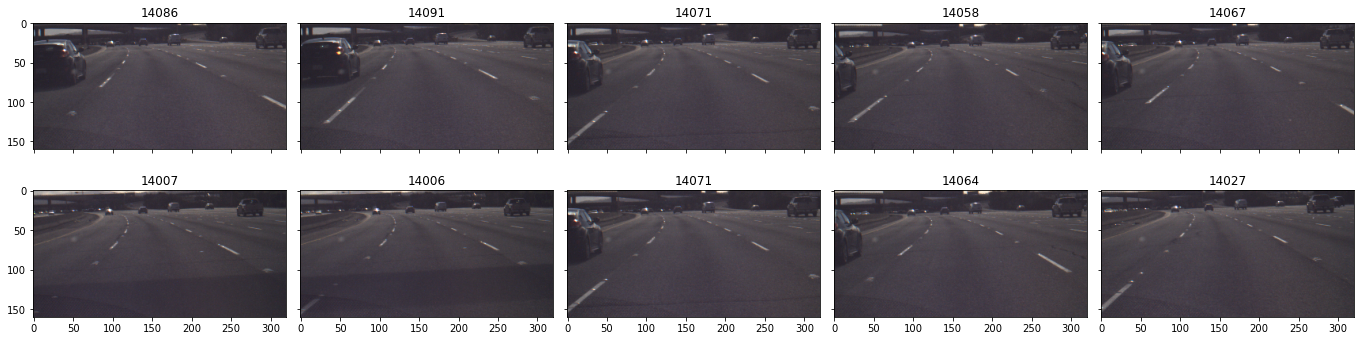

In [9]:
with h5py.File(img_path, 'r') as f:
    x = f['X']
    size = x.shape[0]
    index = random.randint(0, size-200)
    index = 14000
    data = x[index: index + 100]

fig, ax = plt.subplots(2, 5, figsize=(19, 5), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    ix = random.randint(0, 99)
    img = data[ix].swapaxes(0, 2).swapaxes(0, 1)
    ax[i].imshow(img)
    ax[i].set_title(index + ix)
    
plt.tight_layout()
    
print(f'H5 index: {index}')

# Profile images and save

In [21]:
dest_dir = Path.cwd() / 'profile'
profile_images(img_path, lbl_path, dest_dir, show=True)

Generating 106 images
Saving at /home/sanjyot/bimi/robotics/av/working/latcom/profile/2016-01-30--11-24-51.h5


`2016-01-30--11-24-51.h5`: Highway driving (and some urban), first 900 images are garbage

`2016-01-30--13-46-00.h5`: Urban driving, first 1200 images are garbage

### Points to note

1. Steering labels (and other label types) are recorded every 10 ms
2. Images are recorded every 50 ms
3. `cam1_ptr` dataset records the mapping between label and camera frame

# Explore labels

In [99]:
with h5py.File(lbl_path, 'r') as f:
    labels = list(f.keys())[:]
    steering = f['steering_angle'][:]
    time = f['times'][:]
    
labels

['UN_D_cam1_ptr',
 'UN_D_cam2_ptr',
 'UN_D_camphone_ptr',
 'UN_D_lidar_ptr',
 'UN_D_radar_msg',
 'UN_D_rawgps',
 'UN_T_cam1_ptr',
 'UN_T_cam2_ptr',
 'UN_T_camphone_ptr',
 'UN_T_lidar_ptr',
 'UN_T_radar_msg',
 'UN_T_rawgps',
 'blinker',
 'brake',
 'brake_computer',
 'brake_user',
 'cam1_ptr',
 'cam2_ptr',
 'camphone_ptr',
 'car_accel',
 'fiber_accel',
 'fiber_compass',
 'fiber_compass_x',
 'fiber_compass_y',
 'fiber_compass_z',
 'fiber_gyro',
 'fiber_temperature',
 'gas',
 'gear_choice',
 'gps_1_fix',
 'gps_1_pos',
 'gps_1_vel',
 'gps_2_fix',
 'gps_2_pos',
 'gps_2_vel',
 'idx',
 'imu_accel',
 'imu_compass',
 'imu_gyro',
 'rpm',
 'rpm_post_torque',
 'selfdrive',
 'speed',
 'speed_abs',
 'speed_fl',
 'speed_fr',
 'speed_rl',
 'speed_rr',
 'standstill',
 'steering_angle',
 'steering_torque',
 'times',
 'velodyne_gps',
 'velodyne_heading',
 'velodyne_imu']

[Label definition](https://github.com/commaai/research/blob/master/Logs.md)

In [103]:
pd.DataFrame(steering).describe()

,0
count,263583.000000
mean,22.495368
std,605.378073
min,-5121.000000
25%,-13.000000
50%,2.000000
75%,18.584913
max,5011.000000


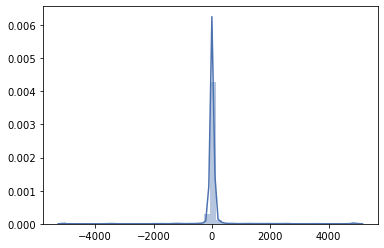

In [102]:
ax = sns.distplot(steering)
# _ = ax.set_title('Steering angle')

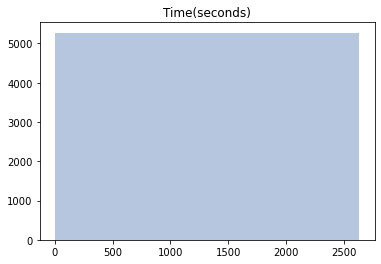

In [74]:
ax = sns.distplot(time, kde=False)
_ = ax.set_title('Time(seconds)')

# Generator pipeline

In [8]:
sample_file = '2016-01-30--11-24-51.h5'

img_path = img_dir / sample_file
lbl_path = lbl_dir / sample_file

filepaths = {
    'lbl_path': str(lbl_path),
    'img_path': str(img_path)
}

In [9]:
comma = CommaData(
    filepaths=filepaths,
    label_shift_steps=6,
    start_index=5000,  # For file '2016-01-30--11-24-51.h5'
    end_index=50000,
    img_shape=(3, 160, 320), 
    validation_split=0.15, 
    batch_size=64
)

In [10]:
train, valid = comma.get_train_valid_datasets()

Data size: 45000
Training size: 38250
Validation size: 6750
Shifting labels by 6 steps (60 ms)


Steering: -0.025456921945650652


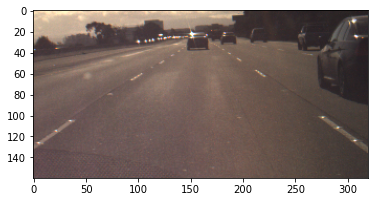

In [54]:
# Check if data looks okay
for itr in train.take(1):
    i, s = itr
    i, s = random.choice(list(zip(i, s)))
    i, s = i.numpy(), s.numpy()
    i = np.moveaxis(i, 0, 2)
    print(f'Steering: {s}')
    plt.imshow(i)

In [19]:
nvidia = load_nvidia(
    learning_rate=1e-4,
    input_shape=(3, 160, 320), 
    data_format='channels_first'
)
nvidia.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 80, 160)       1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 40, 80)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 20, 40)        43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 10, 20)        27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 5, 10)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

# Training

In [20]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
log_dir = project_dir / 'logs'
log_dir.mkdir(parents=True, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [22]:
epochs = 5
print(model_name)
print(model_path)

history = nvidia.fit(
    train, 
    epochs=epochs, 
    validation_data=valid,
    workers=15,
    max_queue_size=30,
    callbacks=[tensorboard_callback]
)
nvidia.save(str(model_path))

comma1.h5
/home/sanjyot/bimi/robotics/av/working/latcom/models/comma1.h5
Epoch 1/5
      2/Unknown - 1s 562ms/step - loss: 15.9083 - mse: 15.9083WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3770s vs `on_train_batch_end` time: 0.6329s). Check your callbacks.
598/598 [==============================] - 201s 336ms/step - loss: 6.4390 - mse: 6.4390 - val_loss: 4.3844 - val_mse: 4.3844
Epoch 2/5
598/598 [==============================] - 190s 318ms/step - loss: 2.0520 - mse: 2.0520 - val_loss: 1.1522 - val_mse: 1.1522
Epoch 3/5
598/598 [==============================] - 196s 327ms/step - loss: 0.6075 - mse: 0.6075 - val_loss: 0.5071 - val_mse: 0.5071
Epoch 4/5
598/598 [==============================] - 192s 322ms/step - loss: 0.2811 - mse: 0.2811 - val_loss: 0.3120 - val_mse: 0.3120
Epoch 5/5
598/598 [==============================] - 189s 316ms/step - loss: 0.1717 - mse: 0.1717 - val_loss: 0.1555 - val_mse: 0.1555


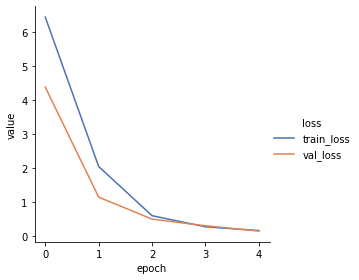

In [26]:
h = history.history
hdf = (
    pd.DataFrame(h)
    .reset_index()
    .rename(columns={'index': 'epoch', 'loss': 'train_loss'})
    .melt(id_vars='epoch', value_vars=['train_loss', 'val_loss'], var_name='loss')
)
sns.relplot(x='epoch', y='value', hue='loss', data=hdf, kind='line', height=4)

## Evaluation

In [27]:
nvidia = tf.keras.models.load_model(model_path)

In [28]:
nvidia.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 80, 160)       1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 40, 80)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 20, 40)        43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 10, 20)        27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 5, 10)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [29]:
pred = nvidia.predict(valid)

In [32]:
# Mean predicting model

y_valid = np.array([])
y_train = np.array([])

for train_batch in tqdm(train.take(-1)):
    y_train_batch = train_batch[-1].numpy()
    y_train = np.concatenate([y_train, y_train_batch])
    
for valid_batch in tqdm(valid.take(-1)):
    y_valid_batch = valid_batch[-1].numpy()
    y_valid = np.concatenate([y_valid, y_valid_batch])
    
mse = np.mean((y_valid - y_train.mean())**2)
print(f'Mean predictor model MSE: {mean_steering}')


Mean predictor model MSE: 7.576581506699094


In [33]:
model_mse = np.mean((pred - y_valid)**2)
print(f'Model MSE: {model_mse}')

Model MSE: 14.662449852375651


### To do
1. ~~Write basic generator to train NVIDIA  model~~

2. ~~Normalize steering / fix NaN~~

2. ~~Shuffle data inside training/validation sets~~

2. ~~Create shuffled training and validation datasets~~

3. ~~Train model, record training performance and results~~

4. ~~Get MSE of average predicting model and compare with the model trained~~

4. ~~Visualize the actual time difference between images/labels through time data in label file~~

4. ~~Add time shifting code into the CommaData class~~

6. ~~Train model, record training performance and results~~

7. ~~Think next steps~~

----------


1. ~~Fix the train and valid datasets for the whole experiment and save indexes. Test if it indices remain same.~~

2. ~~All the random shuffling of training data needs to be deterministic (set numpy seeds everytime you shuffle)~~

3. ~~If a model achieves a similar performance when the loss plateaus for the shifted data as compared to the correct data (in maybe a larger number of epochs), it implies that all the information we need to make a good steering angle decision after 'x' ms offset is already in the image~~

4. ~~Parametrize training script!!

5. ~~Shell script to run a whole episode of experiment~~

6. ~~Test on small data~~

7. Check the determinism when using multi-threaded batch creation during training